# salvo_trough_extraction_demo

Simple notebook to demonstrate using image processing tools to extract trough from a digital elevation model

In [1]:
import os
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Load image
dem_path = os.path.join('..', 'data', 'dem')
filename = 'TestDSM_BEOLong_June16_2025RS.tif'
im = Image.open(os.path.join(dem_path, filename))

In [24]:
# Convert to a numpy array
dem = np.asarray(im).astype(float)

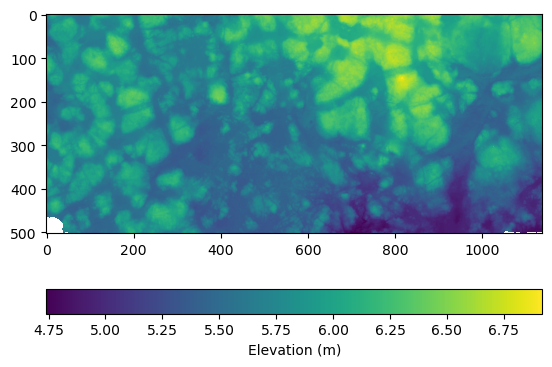

In [25]:
# Plot to examine
plt.imshow(dem)
plt.colorbar(orientation='horizontal', label='Elevation (m)')

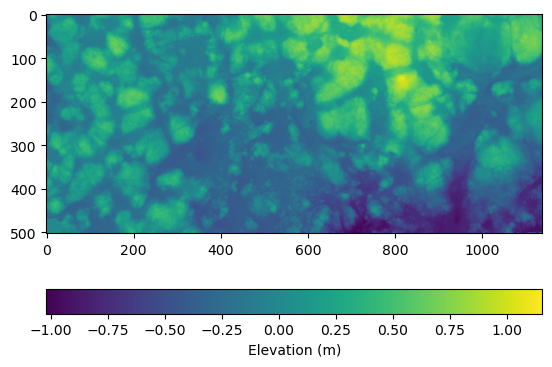

In [42]:
# We have some missing values, fill them with a mean value for simplicity
mv = np.nanmean(dem)
dem[np.isnan(dem)] = mv

# remove the mean for convenience
dem = dem - mv

plt.imshow(dem)
plt.colorbar(orientation='horizontal', label='Elevation (m)')

## Attempt 1: Kernel Laplacian

Consider a 'trough' to represent an area of strongly positive curvature. We can extract these areas by computing a discrete approximation of the Laplacian (i.e., the curvature) over some predefined spatial scale...

In [53]:
# Function for computing discrete laplacian convolutional filters
def lp_filt_5pt(size=3):
    kernel = np.zeros((size, size))
    kernel[size//3:2*size//3, :size//3] = 1
    kernel[size//3:2*size//3, 2*size//3:] = 1
    kernel[:size//3, size//3:2*size//3] = 1
    kernel[2*size//3:, size//3:2*size//3] = 1

    kernel[size//3:2*size//3, size//3:2*size//3] = -4
    
    return kernel

def lp_filt_9pt(size=3):
    kernel = np.zeros((size, size))
    
    # Corners
    kernel[:size//3, :size//3] = 0.25
    kernel[2*size//3:, :size//3] = 0.25
    kernel[:size//3, 2*size//3:] = 0.25
    kernel[2*size//3:, 2*size//3:] = 0.25
    
    
    # Sides
    kernel[size//3:2*size//3, :size//3] = 0.5
    kernel[size//3:2*size//3, 2*size//3:] = 0.5
    kernel[:size//3, size//3:2*size//3] = 0.5
    kernel[2*size//3:, size//3:2*size//3] = 0.5

    # Center
    kernel[size//3:2*size//3, size//3:2*size//3] = -3
    
    return kernel

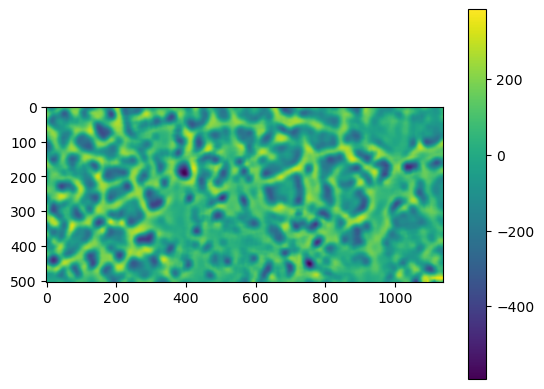

In [64]:
dem_lp = ndimage.convolve(dem, lp_filt_9pt(size=60), mode='nearest')

plt.imshow(dem_lp)
plt.colorbar()

In [83]:
# Compute for a range of different filter sizes

sizes = [48, 66, 84, 102, 120, 138]
dem_lp_stack = np.zeros((dem.shape[0], dem.shape[1], len(sizes)))

for i in np.arange(len(sizes)):
    dem_lp_stack[:,:,i] = ndimage.convolve(dem, lp_filt_9pt(size=sizes[i]), mode='nearest')

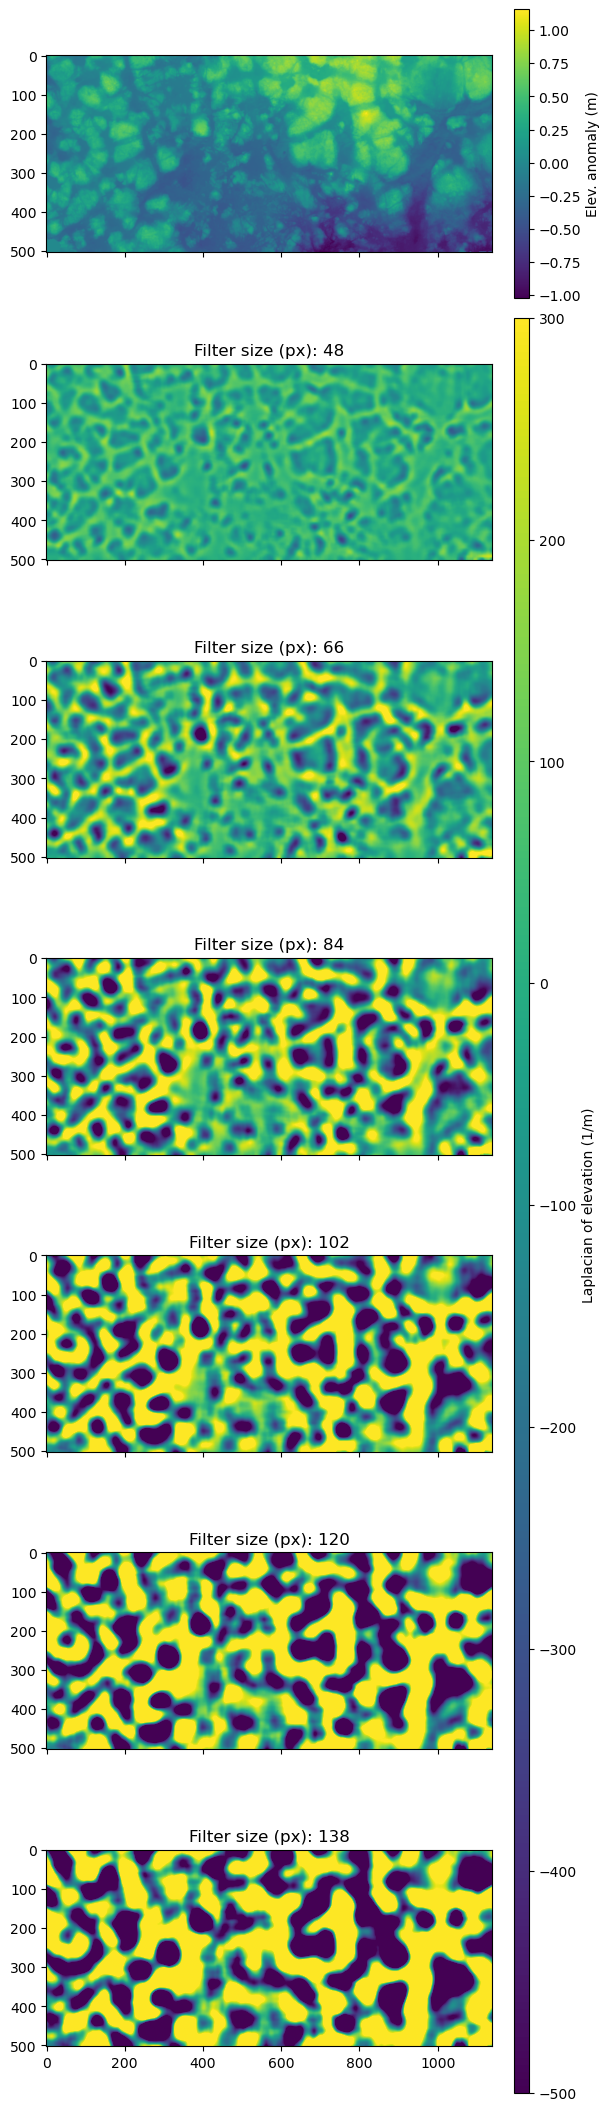

In [84]:
# Plot range of filter sizes
lp_vmin = -500
lp_vmax = 300

f, axs = plt.subplots(len(sizes)+1, 1, sharex=True, sharey=True, figsize=(6,3*(len(sizes)+1)),
                     constrained_layout=True)

# plot dem
h_dem = axs[0].imshow(dem)
f.colorbar(h_dem, orientation='vertical', label='Elev. anomaly (m)')

# plot lp
for i in np.arange(len(sizes)):
    h_lp = axs[i+1].imshow(dem_lp_stack[:,:,i], vmin=lp_vmin, vmax=lp_vmax)
    axs[i+1].set_title('Filter size (px): '+str(sizes[i]))
    
f.colorbar(h_lp, ax=axs[1:], orientation='vertical', label='Laplacian of elevation (1/m)',
          aspect=20*len(sizes))

In [85]:
# Compute for a range of different filter sizes

sizes = [66, 69, 72, 75, 78, 81, 84]
dem_lp_stack = np.zeros((dem.shape[0], dem.shape[1], len(sizes)))

for i in np.arange(len(sizes)):
    dem_lp_stack[:,:,i] = ndimage.convolve(dem, lp_filt_9pt(size=sizes[i]), mode='nearest')

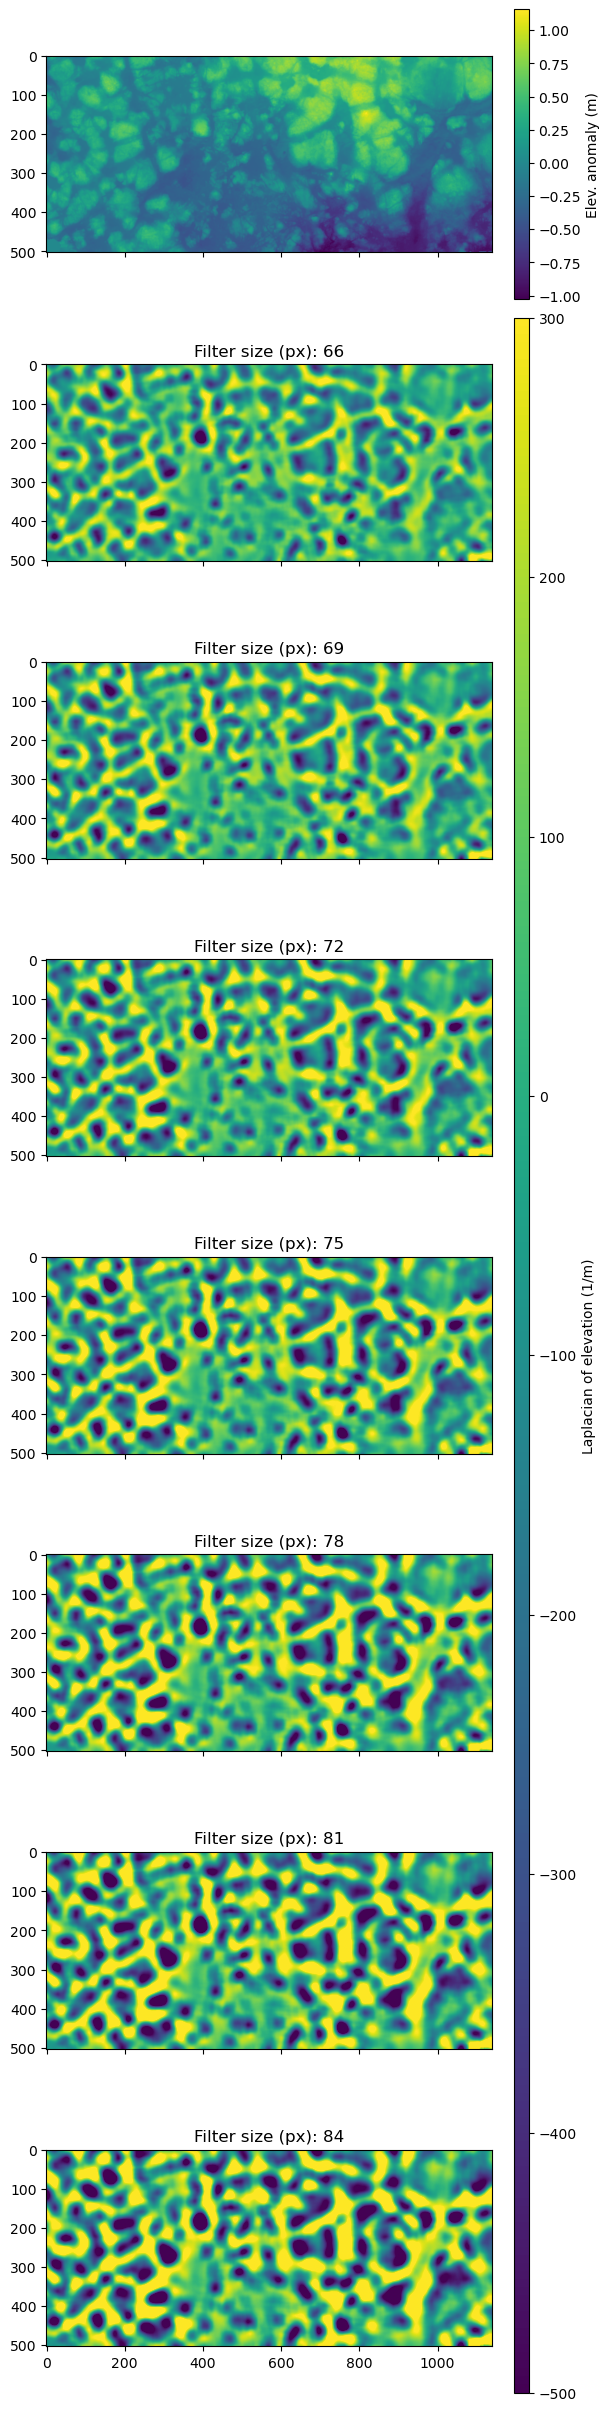

In [86]:
# Plot range of filter sizes
lp_vmin = -500
lp_vmax = 300

f, axs = plt.subplots(len(sizes)+1, 1, sharex=True, sharey=True, figsize=(6,3*(len(sizes)+1)),
                     constrained_layout=True)

# plot dem
h_dem = axs[0].imshow(dem)
f.colorbar(h_dem, orientation='vertical', label='Elev. anomaly (m)')

# plot lp
for i in np.arange(len(sizes)):
    h_lp = axs[i+1].imshow(dem_lp_stack[:,:,i], vmin=lp_vmin, vmax=lp_vmax)
    axs[i+1].set_title('Filter size (px): '+str(sizes[i]))
    
f.colorbar(h_lp, ax=axs[1:], orientation='vertical', label='Laplacian of elevation (1/m)',
          aspect=20*len(sizes))

## Attempt 2: Watershed algorithm

Consider that the defining feature of a 'trough' is that is separates two polygons. An alternative approach to finding troughs is to first identify the borders of polygons. Rough approach:

1. Segment image into polygons using watershed algorithm applied to inverted topography, starting from local maxima.
2. Within each polygon, there is a surface of maximum gradient. Identify that surface as the edge of the polygon (maybe could use max negative curvature instead). Crop each polygon to this area. We may need some way to distinguish between 'troughs' between polygons, and just generally low lying areas. Perhaps some sort of curvature or cross-sectional distance metric is appropriate.